In [68]:
import requests
import json

import pandas as pd
from datetime import datetime

headers = {
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'no-cache',
    'origin': 'https://edition.cnn.com',
    'pragma': 'no-cache',
    'priority': 'u=1, i',
    'referer': 'https://edition.cnn.com/',
    'sec-ch-ua': '"Chromium";v="128", "Not;A=Brand";v="24", "Google Chrome";v="128"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'cross-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36',
}

response = requests.get('https://production.dataviz.cnn.io/index/fearandgreed/graphdata/2021-01-01', headers=headers)

with open('../datasets/fear_greed.json', 'w') as f:
    json.dump(response.json(), f, indent=4)


In [69]:
with open('./datasets/fear_greed.json', 'r') as file:
    data = json.load(file)

fear_and_greed_data = data.get('fear_and_greed_historical', {}).get('data', {})

for entry in fear_and_greed_data:
    timestamp = entry['x'] / 1000  # Convert milliseconds to seconds
    entry['x'] = datetime.utcfromtimestamp(timestamp).strftime('%d-%m-%Y')


extracted_data = [{'Date': entry['x'], 'fear_and_greed': entry['y']} for entry in fear_and_greed_data[:-1]]

df = pd.DataFrame(extracted_data)

df = df[:-1]
df.to_csv('./datasets/historical_prices.csv', index=False)

In [70]:
import yfinance as yf
import pandas as pd

historical_prices = pd.read_csv("./datasets/historical_prices.csv")
historical_prices['Date'] = pd.to_datetime(historical_prices['Date'], format='%d-%m-%Y')
historical_prices.set_index('Date', inplace=True)

tickers = {
    "GC=F": "gold",
    "CL=F": "crude_oil",
    "PL=F": "platinum",
    "DX-Y.NYB": "usd_index"
}

for ticker, column_name in tickers.items():
    data = yf.download(ticker, start="2021-01-01", end="2024-09-20")
    open_prices = data['Open']
    df = pd.DataFrame(open_prices)
    df.columns = [column_name]
    
    historical_prices = historical_prices.join(df, how='outer')

# Save the combined data to a CSV file
historical_prices.to_csv("./datasets/historical_prices.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
import hopsworks
import pandas as pd

df = pd.read_csv('./datasets/historical_prices.csv')

project = hopsworks.login()
fs = project.get_feature_store()

feature_group = fs.get_or_create_feature_group(
    name="historical_prices",
    version=1,
    primary_key=["Date"],
    description="Historical prices and fear rating"
)

feature_group.insert(df)

In [72]:
PARAMETERS = ['fear_and_greed', 'crude_oil', 'usd_index', 'platinum']
TEST_SPLIT = 5

In [76]:
from prophet import Prophet

model = Prophet()

for parameter in PARAMETERS:
    model.add_regressor(parameter)

df=pd.read_csv('./datasets/historical_prices.csv')
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
df=df.rename(columns={'date':'ds', 'gold':'y'})

#df = df.drop(df.tail(TEST_SPLIT).index)

model.fit(df)

2024-09-20 07:01:07,117 DEBUG: cmd: where.exe tbb.dll
cwd: None
2024-09-20 07:01:07,206 DEBUG: TBB already found in load path
2024-09-20 07:01:07,227 INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-09-20 07:01:07,247 DEBUG: input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpn_usfkjr\ey5zysc0.json
2024-09-20 07:01:07,354 DEBUG: input tempfile: C:\Users\Admin\AppData\Local\Temp\tmpn_usfkjr\yobuamn7.json
2024-09-20 07:01:07,357 DEBUG: idx 0
2024-09-20 07:01:07,358 DEBUG: running CmdStan, num_threads: None
2024-09-20 07:01:07,359 DEBUG: CmdStan args: ['D:\\Rohan\\ML\\SafariBackup\\gold_price_prediction\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=51461', 'data', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpn_usfkjr\\ey5zysc0.json', 'init=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpn_usfkjr\\yobuamn7.json', 'output', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmpn_usfkjr\\prophet_model_tfs8t7u\\

07:01:07 - cmdstanpy - INFO - Chain [1] start processing


2024-09-20 07:01:07,360 INFO: Chain [1] start processing


07:01:07 - cmdstanpy - INFO - Chain [1] done processing


2024-09-20 07:01:07,663 INFO: Chain [1] done processing


In [77]:
forecast = model.predict(df)
prediction = forecast[['yhat']]

print(prediction)

            yhat
0    1910.769967
1    1903.145234
2    1916.590267
3    1913.328089
4    1906.224899
..           ...
928  2510.996448
929  2530.509192
930  2517.849975
931  2522.178058
932  2509.346479

[933 rows x 1 columns]


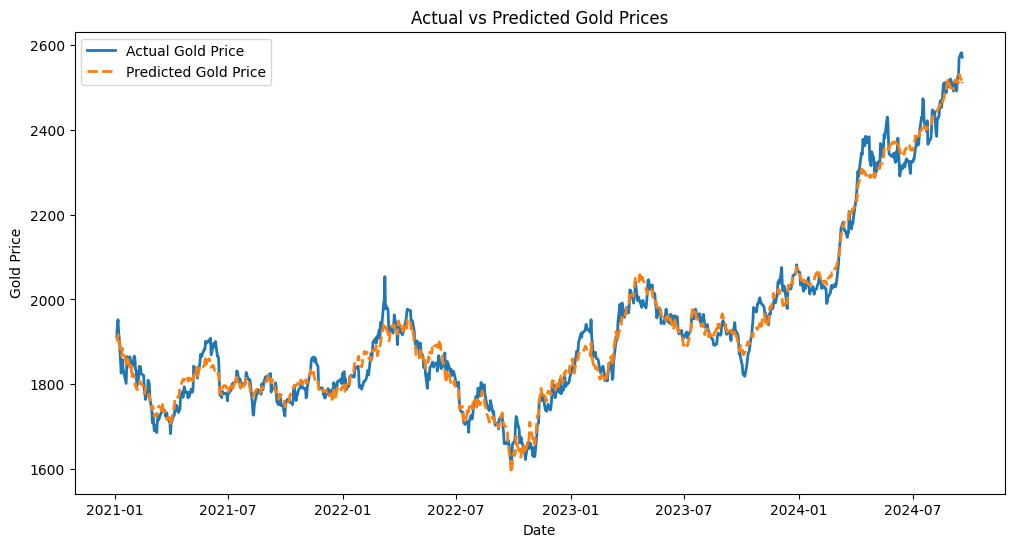

In [78]:
import matplotlib.pyplot as plt

forecast = model.predict(df)
prediction = forecast[['ds', 'yhat']]

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Gold Price', linewidth=2)
plt.plot(prediction['ds'], prediction['yhat'], label='Predicted Gold Price', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()